In [17]:
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from IMPORT_DATAFRAME_JSON_HDF5 import *
%matplotlib notebook
import os


In [18]:

Phase_1_complete =  pd.read_csv('power_today_minute_1.csv', names = ['timestamp','P'])
Phase_2_complete  = pd.read_csv('power_today_minute_2.csv', names = ['timestamp','P'])
Phase_3_complete  = pd.read_csv('power_today_minute_3.csv', names = ['timestamp','P'])

In [19]:
#Event dataframe anlegen zur späteren Auswertung der An/Abschaltevents
Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index' ,'Ladevorgang', 'Status', 'Ladeleistung','minuten_index_Abschaltung','timestamp_abschalt'])


einschaltvorgang_gefunden = 0
#iteration über alle Phasen
for Phase in range (1,4):
    print('Phase: ' + str(Phase))
    print('_______________________')
    #Einlesen der aktuellen .csv einer Phase
    P_Phase = pd.read_csv('power_today_minute_'+str(Phase)+'.csv', names = ['timestamp','P'])
    Phase_mit_delta = P_Phase
    Phase_mit_delta['P_delta'] = 0
    Leerlaufleistung_Phase = P_Phase[0:100]['P'].mean()
    
    #Iteration über alle Werte dieser Phase
    for row in range(1,len(P_Phase)):
        # daten import
        Timestamp = P_Phase.iloc[row]['timestamp']
        minuten_index = row
        P_new = P_Phase.iloc[row]['P']
        P_old = P_Phase.iloc[row-1]['P']
        P_delta = P_new-P_old
        Phase_mit_delta.loc[row, 'P_delta'] = P_delta

        # ist delta P relevant
        if(P_delta > 100.0):
            # Prüfen ob Ladenvorgang beginnt/beendet
            #Wenn delta P positiv ---> event kreieren um später zu checken ob es ein Einschaltvorgang war
            Event_df.loc[len(Event_df)]= [Timestamp, Phase, minuten_index, 'ein', 'not checked', 0,0,0]
            print(Event_df)


        #Check events: Überprüfen ob vorher eingetragenes event wirklich ein Einschaltvorgang ist
        for row_event in range(0,len(Event_df)):
            #condition to check event
            minuten_index_event = Event_df.iloc[row_event]['minuten_index'] 
            #Check auf Einschaltvorgang
            if ((minuten_index_event+3 == minuten_index) & (Event_df.iloc[row_event]['Ladevorgang'] == 'ein')& (Event_df.iloc[row_event]['Phase'] == Phase)):
                Ladeleistung = P_Phase.iloc[minuten_index_event+3]['P'] - P_Phase.iloc[minuten_index_event-3]['P'] 
                sum_delta_P = Phase_mit_delta[minuten_index_event:minuten_index_event+3]['P_delta'].sum()
                deviation = abs(Ladeleistung-sum_delta_P)/Ladeleistung 
                if abs(Ladeleistung-sum_delta_P)/Ladeleistung >0.01:
                    Event_df = Event_df.drop(row_event)
                else:
                    Event_df.loc[row_event, ['Status', 'Ladeleistung']] = ['checked', Ladeleistung]

    #Checken ob aktuelle Leistung das Ende eines Einschaltvorgangs impliziert        

        #Soll Leistung = Leistung die auf der Phase anliegen sollte, wenn alle zuvor ladenden Autos noch an der Phase hängen würden
        Soll_Leistung = Leerlaufleistung_Phase + Event_df[(Event_df['Ladevorgang']=='ein') & (Event_df['minuten_index'] <= minuten_index)& (Event_df['minuten_index_Abschaltung'] == 0) & (Event_df['Phase'] == Phase)]['Ladeleistung'].sum()
        #Aktuelle Leistung (neuer Messwert)
        Ist_Leistung = P_new 
        #Residuale Leistung 
        P_residual = Soll_Leistung - Ist_Leistung
        #print('P_res: ' + str(P_residual) +  'Soll: ' + str(Soll_Leistung)+ 'Ist_Leistung: ' + str(Ist_Leistung)+'minuten index: ' + str(minuten_index))
        #Überprüfen ob fehlende Leistung (P_residual) zu einem zuvor ladenden Auto passt
        for charge in range(0, len(Event_df)):
            if ((Event_df.iloc[charge]['Ladevorgang'] == 'ein') & (Event_df.iloc[charge]['minuten_index_Abschaltung'] == 0)):
                Ladeleistung_auto = Event_df.iloc[charge]['Ladeleistung']
                deviation_P = (abs(Ladeleistung_auto-P_residual)/Ladeleistung_auto)
                if ((deviation_P <0.02)):
                        Event_df.loc[charge,['minuten_index_Abschaltung']] = minuten_index
                        Event_df.loc[charge,['timestamp_abschalt']] = Timestamp
                        einschaltvorgang_gefunden = 1
                        #print('Phase: '+ str(Phase)+'P_res: ' + str(P_residual) +  'Soll: ' + str(Soll_Leistung)+ 'Ist_Leistung: ' + str(Ist_Leistung)+'minuten index: ' + str(minuten_index))

                        #print(deviation_P)
                        #print('tada')



Phase: 1
_______________________
      timestamp Phase minuten_index Ladevorgang       Status Ladeleistung  \
0  1.505287e+09     1           557         ein  not checked            0   

  minuten_index_Abschaltung timestamp_abschalt  
0                         0                  0  
      timestamp Phase minuten_index Ladevorgang       Status Ladeleistung  \
0  1.505287e+09     1           557         ein  not checked            0   
1  1.505287e+09     1           558         ein  not checked            0   

  minuten_index_Abschaltung timestamp_abschalt  
0                         0                  0  
1                         0                  0  


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars


      timestamp Phase minuten_index Ladevorgang       Status Ladeleistung  \
0  1.505287e+09     1           557         ein      checked         3856   
1  1.505304e+09     1           845         ein  not checked            0   

  minuten_index_Abschaltung timestamp_abschalt  
0                       590        1.50529e+09  
1                         0                  0  
      timestamp Phase minuten_index Ladevorgang       Status Ladeleistung  \
0  1.505287e+09     1           557         ein      checked         3856   
1  1.505304e+09     1           845         ein  not checked            0   
2  1.505304e+09     1           846         ein  not checked            0   

  minuten_index_Abschaltung timestamp_abschalt  
0                       590        1.50529e+09  
1                         0                  0  
2                         0                  0  
Phase: 2
_______________________
      timestamp Phase minuten_index Ladevorgang       Status Ladeleistung  \
0  1.5

      timestamp Phase minuten_index Ladevorgang       Status Ladeleistung  \
0  1.505287e+09     1           557         ein      checked         3856   
1  1.505304e+09     1           845         ein      checked         3583   
2  1.505279e+09     2           430         ein      checked         3442   
3  1.505287e+09     2           557         ein      checked         3846   
4  1.505291e+09     2           628         ein      checked         3642   
5  1.505305e+09     2           858         ein      checked         3603   
6  1.505287e+09     3           557         ein      checked         3881   
7  1.505299e+09     3           765         ein  not checked            0   

  minuten_index_Abschaltung timestamp_abschalt  
0                       590        1.50529e+09  
1                       923        1.50531e+09  
2                       775         1.5053e+09  
3                       590        1.50529e+09  
4                       710         1.5053e+09  
5           

In [20]:
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.505287e+09,1,557,ein,checked,3856,590,1.50529e+09
1,1.505304e+09,1,845,ein,checked,3583,923,1.50531e+09
2,1.505279e+09,2,430,ein,checked,3442,775,1.5053e+09
3,1.505287e+09,2,557,ein,checked,3846,590,1.50529e+09
4,1.505291e+09,2,628,ein,checked,3642,710,1.5053e+09
5,1.505305e+09,2,858,ein,checked,3603,884,1.50531e+09
6,1.505287e+09,3,557,ein,checked,3881,590,1.50529e+09
7,1.505299e+09,3,765,ein,checked,3592,878,1.50531e+09


In [21]:

Event_df = Event_df.sort_values('timestamp')
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
2,1.505279e+09,2,430,ein,checked,3442,775,1.5053e+09
0,1.505287e+09,1,557,ein,checked,3856,590,1.50529e+09
3,1.505287e+09,2,557,ein,checked,3846,590,1.50529e+09
6,1.505287e+09,3,557,ein,checked,3881,590,1.50529e+09
4,1.505291e+09,2,628,ein,checked,3642,710,1.5053e+09
7,1.505299e+09,3,765,ein,checked,3592,878,1.50531e+09
1,1.505304e+09,1,845,ein,checked,3583,923,1.50531e+09
5,1.505305e+09,2,858,ein,checked,3603,884,1.50531e+09


In [22]:
# Zusammenfassen von mehrphasigen Ladevorängen
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Ladeleistung','Ladevorgang_ende'])


for events in range(0,len(Event_df)):
    timestamp = Event_df.iloc[events]['timestamp']
    timestamp_abschaltung = Event_df.iloc[events]['timestamp_abschalt']
    Phase = []
    Ladeleistung = []
    same_events = Event_df.loc[Event_df['timestamp'] == Event_df.iloc[events]['timestamp']]
    event_count = len(same_events)
    for a in range (0,event_count):
        Phase.append(same_events.iloc[a]['Phase'])
        Ladeleistung.append(str(same_events.iloc[a]['Phase'])+': '+str(same_events.iloc[a]['Ladeleistung']))
    if (len(ladevorgang_df.loc[ladevorgang_df['timestamp_start'] == timestamp]) !=1):
        ladevorgang_df.loc[len(ladevorgang_df)]= [timestamp, Phase, Ladeleistung, timestamp_abschaltung]
ladevorgang_df

,timestamp_start,Phasen,Ladeleistung,Ladevorgang_ende
0,1.505279e+09,[2],[2: 3442.0],1.505300e+09
1,1.505287e+09,"[1, 2, 3]","[1: 3856.0, 2: 3846.0, 3: 3881.0]",1.505289e+09
2,1.505291e+09,[2],[2: 3642.0],1.505296e+09
3,1.505299e+09,[3],[3: 3592.0],1.505306e+09
4,1.505304e+09,[1],[1: 3583.0],1.505309e+09
5,1.505305e+09,[2],[2: 3603.0],1.505307e+09


<IPython.core.display.Javascript object>


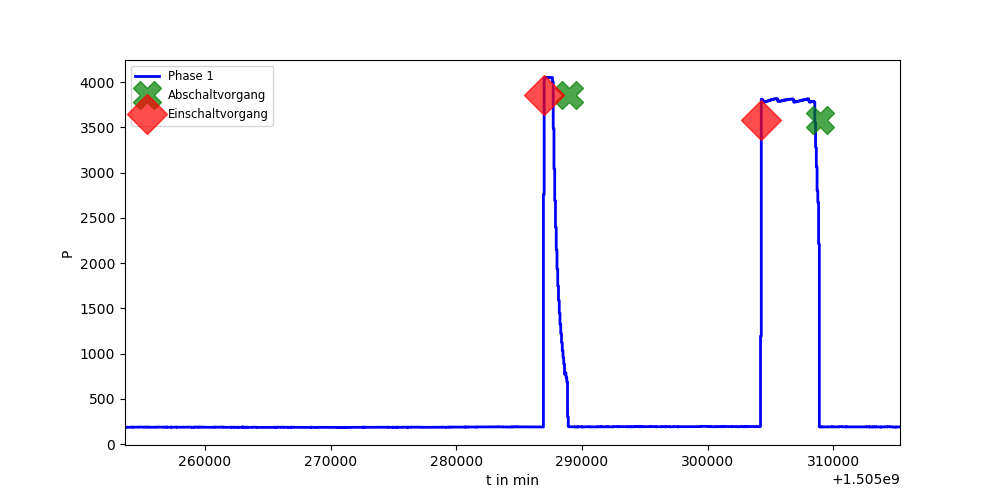

<IPython.core.display.Javascript object>


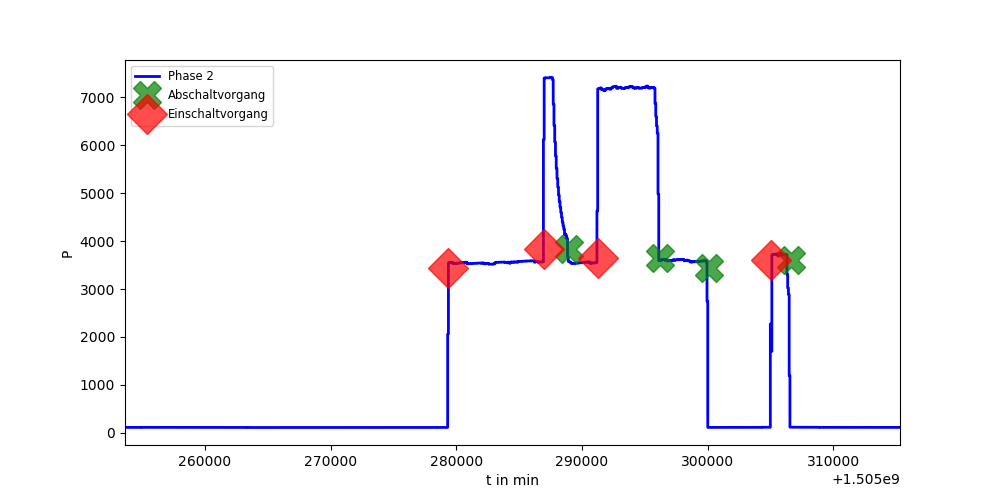

<IPython.core.display.Javascript object>


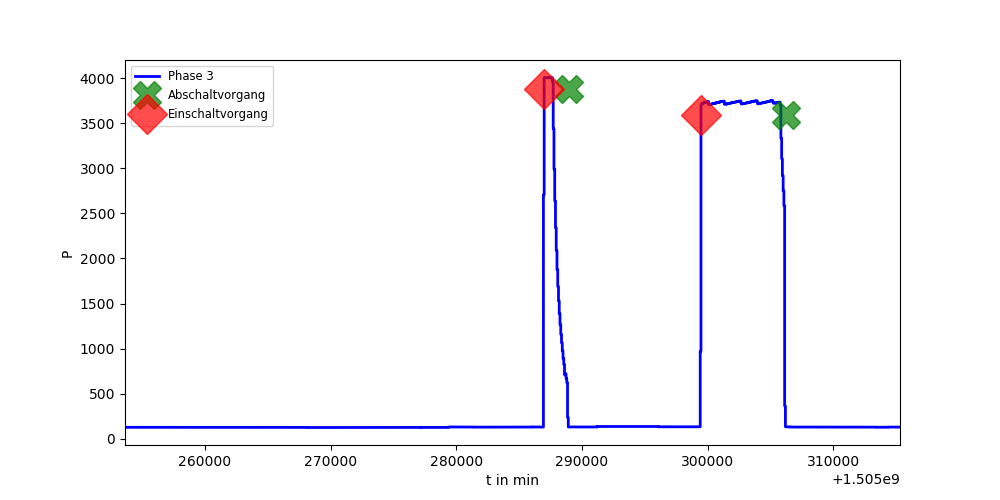

In [23]:
#Plotten aller phasen mit ein und ausschaltvorgang
for Phase in range (1,4):
    Phase_P = pd.read_csv('power_today_minute_'+str(Phase)+'.csv', names = ['timestamp','P'])
    plt.figure(figsize=(10,5))
    plt.step(Phase_P['timestamp'],Phase_P['P'], color="blue", linewidth=2, label='Phase '+str(Phase))
    plt.plot(Event_df[Event_df.Phase == Phase]['timestamp_abschalt'], Event_df[Event_df.Phase == Phase]['Ladeleistung'], "X",color="green", markersize=20,alpha=.7, label='Abschaltvorgang')
    plt.plot(Event_df[Event_df.Phase == Phase]['timestamp'], Event_df[Event_df.Phase == Phase]['Ladeleistung'], "D", color="red", markersize=20,alpha=.7, label='Einschaltvorgang')
    plt.legend(loc='upper left', frameon=True, fontsize = 'small')
    plt.xlim([Phase_mit_delta.iloc[1]['timestamp'],Phase_mit_delta.iloc[len(Phase_mit_delta)-1]['timestamp']])
    plt.ylabel('P')
    plt.xlabel('t in min')